The below Code for Experiment 3 of the Deep Learning Course was gotten from the below reference:
"https://medium.com/@jeewonkim1028/sentiment-analysis-in-keras-using-attention-mechanism-on-yelp-reviews-dataset-322bd7333b8b"

To ensure the code below would be able to fulfill the requirements for the assignment, I had to  make slight chamges to the code.

In [ ]:
# !pip install nltk

In [ ]:
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

# Reference Yelp reviews json dataset: https://github.com/rekiksab/Yelp-Data-Challenge-2013/blob/master/yelp_challenge/yelp_phoenix_academic_dataset/yelp_academic_dataset_review.json 
review_json_path = r'yelp_academic_dataset_review.json'


size = 229907 #according to the yelp dataset
review = pd.read_json(review_json_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int}, nrows=size)#nrows according to total numbers of rows or size of the dataset

df_review_text=review[['stars','text']]

In [ ]:
df_review_text

In [ ]:
num_missing_text = np.sum(df_review_text['text'].isnull())
print('num missing text: {}'.format(num_missing_text))

In [ ]:
# !pip install matplotlib

<Axes: xlabel='stars'>

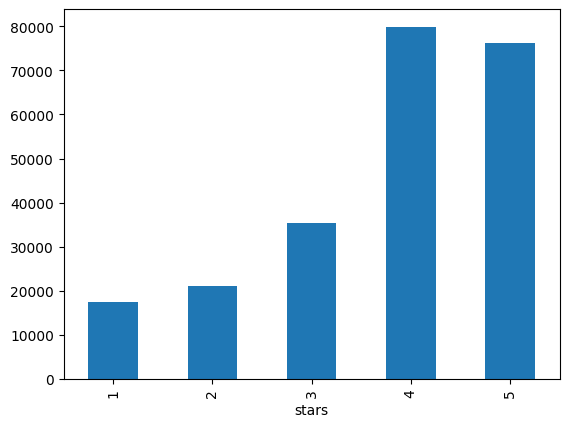

In [5]:
import matplotlib

df_review_text['stars'].value_counts(dropna=False).sort_index().plot(kind='bar')

In [ ]:
df_review_text['text'].iloc[0]

In [ ]:
df_review_text['sentiment'] = np.where(df_review_text['stars'] > 3, 1, 0)

print('{:.2f}% are positive reviews'.format(df_review_text['sentiment'].mean()*100))

df_review_text

In [ ]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df_review_text['Processed_Reviews'] = df_review_text.text.apply(lambda x: clean_text(x))
df_review_text.head()

In [ ]:
df_review_text.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_review_text, test_size=0.01)

MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df_train['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df_train['Processed_Reviews'])

RNN_CELL_SIZE = 32

MAX_LEN = 60   # Since our mean length is 56.6
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y_train = df_train['sentiment']

In [ ]:
df_review_text

In [13]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [14]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [32]:
# Network Depth
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

# Additional bidirectional LSTM layers
# lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True), name="bi_lstm_2")(lstm)
# (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_3")(lstm)
# lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True), name="bi_lstm_4")(lstm)
# (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_5")(lstm)
# lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True), name="bi_lstm_6")(lstm)
# (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_7")(lstm)
# lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True), name="bi_lstm_8")(lstm)
# (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_9")(lstm)
# lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True), name="bi_lstm_10")(lstm)
# (lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_11")(lstm)
# # Add more layers as needed


In [35]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

# Removal of the globalMaxPool1D could be trouble
#globmax = GlobalMaxPool1D()(context_vector)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)#Dropout Rate
output = Dense(1, activation="sigmoid")(dropout)

model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
# summarize layers
print(model.summary())

In [ ]:
# !pip install pydot

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [41]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)


In [ ]:
# Model training and evaluation
BATCH_SIZE = 100
EPOCHS = 10

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, callbacks=[early_stopping])

history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

In [54]:
y_test=df_test['sentiment']

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df_test['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df_test['Processed_Reviews'])

X_test = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)

In [ ]:
prediction = model.predict(X_test)

In [56]:
y_pred = (prediction > 0.5)

In [ ]:
# !pip install seaborn


In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

report = classification_report(y_test, y_pred)
print(report)


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

In [ ]:
#plt.style.use("fivethirtyeight")

# Cross Validation Classification Accuracy

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams["figure.figsize"] = (12, 18)

def plot_metrics(history):
    metrics = [
        "loss",
        "tp", "fp", "tn", "fn",
        "accuracy",
        "precision", "recall",
        "auc",
    ]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(5, 2, n + 1)
        plt.plot(
            history.epoch,
            history.history[metric],
            color=colors[0],
            label="Train",
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1] * 1.2])
        elif metric == "accuracy":
            plt.ylim([0.4, 1])
        elif metric == "fn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "fp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "precision":
            plt.ylim([0, 1])
        elif metric == "recall":
            plt.ylim([0.4, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

plot_metrics(history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

mpl.rcParams["figure.figsize"] = (6, 6)

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score

# Binarize the output
y_bin = label_binarize(y_test, classes=[0, 1])
n_classes = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Define a function for making predictions
def predict_yelp(review_text):
    processed_text = clean_text(review_text)
    tokenized_text = tokenizer.texts_to_sequences([processed_text])
    padded_text = pad_sequences(tokenized_text, maxlen=MAX_LEN)
    prediction = model.predict(padded_text)[0][0]
    sentiment_label = "Positive" if prediction > 0.5 else "Negative"
    return sentiment_label, prediction

# Example usage of the predict function
prediction_result_yelp = predict_yelp('I have always been a fan of Burlington\'s deals, however I will not be shopping at this one again. I went to return a belt... pretty simple. Instead, I stood in the customer service line for 15 minutes thanks to an employee of Burlington buying/putting things on layaway. It took three other staff to help her out. There were no words said to me except \'Hold on\'. I was pissed. When the lady was finally done, the employee at the service asked \'what do you want?\' Serious help is needed there!\n If you work in the area of \'customer service\' I think you should have some.')
print("Sentiment:", prediction_result_yelp[0])
print("Probability:", prediction_result_yelp[1])